In [1]:
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
import numpy as np
import pandas as pd
from teneto import TemporalNetwork
import json
from collections import defaultdict
import warnings
from os import listdir
from tqdm import tqdm
import math
import bz2
from os.path import isfile, join
from scipy import sparse
import graphlets
import PyBliss
import pandas as pd
from scipy.ndimage.filters import gaussian_filter1d
import os
import seaborn as sns

import pickle
import networkx as nx

from multiprocessing import Queue, Process
warnings.filterwarnings("ignore")

/home/florian/.local/lib/python3.6/site-packages/nilearn/__init__.py:69: FutureWarning: Python 3.6 support is deprecated and will be removed in release 0.10 of Nilearn. Consider switching to Python 3.8 or 3.9.
  _python_deprecation_warnings()
/home/florian/.local/lib/python3.6/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [2]:
n_cores = 100  # 2-4
PATH = "/mnt/erebor1/Daten/ABI2/crawls/dreddit/"
min_posts = 10

files =  [join(PATH + "comments/", f) for f in listdir(PATH + "comments/") 
          if isfile(join(PATH + "comments/", f))]

n_files = 250  # 5

<h3> Beschreibe den Kommentarbaum von Submissions als Graphlet-Vektor </h3>

- Geht der Kommentarbaum eher in die Breite oder eher in die Länge?

- Wie verhält sich die Graphlet Verteilung zu Kommentaren des Autors zu der von anderen Nutzern?

- Konkret wollen wir wissen, ob sich die Interaktion bzw. Reaktion anderer Nutzer auf eine Kampagne anders äußert, als bei normalen oder Trendthemen.

Wir vergleichen hierzu verschiedene Szenarien (und den Durchschnittswert) und hoffen, statistisch signifikante Unterschiede in der Ausbreitung zu finden. Etwa

1. Krieg in der Ukraine

2. Project Veritas

3. Offizielle Posts von Regierungsorganisation

4. kleines Nischenthema

5. Durchschnittliche Ausbreitung bei beliebigen Themen


Zunächst gestalten wir jedoch eine Wrappermethode, welche eine Liste von Keywords zu einem konkreten Thema entgegen nimmt und die Aufbereitung der Daten vornimmt. Die Wrappermethode muss dabei:

1. Alle Kommentare zu einem gewünschten Thema durch Keyword Matching extrahieren (bspw. durch Comparison im Titel der Submission oder durch das zugehörige Subreddit)

2. Aus den Kommentaren einen vollständigen Kommentarbaum extrahieren (soweit Daten verfügbar), so dass jeder Baum individuell betrachtet werden kann

3. Jeder Kommentarbaum muss eine Annotation bzgl. Nutzern (d.h. Knotenattribute) und Interaktionszeiten (d.h. Kantenattribute) besitzen

4. Aus dem Kommentarbaum extrahieren werden danach die grundlegenden Graphlets, sowie die Gesamtzahl der Kommentare (zur Normierung) extrahiert. Von Relevanz sind dabei 4-Node Graphlets des Typs 3 (Line) und 4 (Intersection) und 5-Node Graphlets der gleichen Typen (9 und 10)

5. Die Extraktion soll auf zwei Arten erfolgen:

 - einmal für jeden Knoten (und damit seiner 5 Hop Nachbarschaft), die nach vollständiger Abarbeitung des Baumes zu einem einzelnen Vektor summiert werden, welcher dann die Graphlet-Beschreibung der Submission darstellt
 - einmal aggregiert auf Kommentare des (Post-)Autors bzw. nur auf reagierende Nutzer. Dies soll eine Gegenüberstellung von "Content Creators" und "Adopters" darstellen
 
6. Abschließend müssen verallgemeinerte Statistiken zu dem jeweiligen Szenario erstellt werden, indem die Teilergebnisse von einzelnen Submissions zusammengefügt werden. Wir erhoffen uns hier, das jeder Typ von Szenarien eine unterschiedliche Ausbreitungsdynamik hinsichtlich der Kommentarstrukur besitzt

In [3]:
# 1. Keyword Matching im Titel
def is_relevant_title(title, keywords):
    return any(keyword in title.lower() for keyword in keywords)

In [4]:
# 2. Kommentarbäume in einen DiGraph schreiben
def create_comment_forest(file_paths, keywords):
    G = nx.DiGraph()
    
    for file_path in tqdm(file_paths):
        with bz2.open(file_path, "rt") as file:
            for line in file:
                comment = json.loads(line)
                comment_id = comment.get("name")
                parent_id = comment.get("parent_id")
                submission_id = comment.get("link_id")
                subreddit_id = comment.get("subreddit_id")
                subreddit_name = comment.get("subreddit")
                user_id = comment.get("author_fullname")
                is_submitter = comment.get("is_submitter")
                link_title = comment.get("link_title")
                created_at = comment.get("created_utc")
                
                if not is_relevant_title(link_title, keywords):
                    continue
                    
                # 3. Knoten- und Kantenattribute anbei
                if parent_id == submission_id:  # top level comment
                    G.add_node(parent_id, subreddit_id=subreddit_id, is_root=True, link_title=link_title)
                    G.add_node(comment_id, user_id=user_id, is_submitter=is_submitter, is_root=False)
                    G.add_edge(parent_id, comment_id, created_at=created_at)
                elif G.has_node(parent_id):  # only insert comment if we know the start of a comment forest
                    G.add_node(comment_id, user_id=user_id, is_submitter=is_submitter, is_root=False)
                    G.add_edge(parent_id, comment_id, created_at=created_at)
                    
    return G

In [5]:
def evaluate_submission_subgraph(queue_batches, queue_results):
    
    worker_results = []
    
    has_work = True
    while has_work:
        idx = queue_batches.get()
        
        if idx is None:  # all batches have been distributed
            has_work = False
            continue
            
            
        # Extraktion von Orbits mit https://github.com/benedekrozemberczki/OrbitalFeatures
        
        # call orbital strike
        os.system("python3.8 OrbitalFeatures/src/main.py --graphlet-size 4 --graph-input " \
                  "tmp/submission_graph{}.TMP --output tmp/orbital_features{}.TMP".format(idx, idx))

        # collect results
        df = pd.read_csv("tmp/orbital_features{}.TMP".format(idx))
        worker_results.append(df)
        
        # clean up
        os.system("rm tmp/submission_graph{}.TMP orbital_features{}.TMP".format(idx, idx))
        
    # end while
    
    
    # provide results via queue_results
    queue_results.put(worker_results)
    

In [140]:
def create_comment_tree_stats(keywords, min_size=1, max_size=1000):
    comment_forest = create_comment_forest(files[:n_files], keywords)
    
    q_batches = Queue(n_cores)
    q_results = Queue(n_cores)
    
    workers = [Process(target=evaluate_submission_subgraph, args=(q_batches, q_results)) 
               for _ in range(n_cores)]
    
    for w in workers:
        w.start()
        
    with open("forest_stats_median.csv", "w") as file:
        file.write("total_comments,root_degree,avg_tree_size,avg_depth\n")

    
    # for each post 
    for idx, submission_graph in enumerate(nx.weakly_connected_components(comment_forest)):
        
        # skip posts with less than min_size comments
        if not min_size < len(submission_graph) < max_size:
            continue
        
        # extract submission subgraph
        H = comment_forest.subgraph(submission_graph).copy()
        
        # extract various statistical properties
        root = [x for x in submission_graph if comment_forest.nodes(data=True)[x]['is_root']][0]
        root_degree = H.degree(root)
        total_comments = len(H.nodes()) - 1
        comment_tree_sizes = []
        comment_tree_depths = []
        
        # 4. extract submission graphlets via Orbital Strike
        node_map = {n:i for i, n in enumerate(H.nodes())}
        inv_node_map = {v:k for k,v in node_map.items()}
        H = nx.relabel_nodes(H, node_map, copy=True)
        
        root = node_map[root]
        
        """
        print(root)
        
        pos=graphviz_layout(H, prog='dot')
        
        plt.figure(figsize=(20, 10))
        nx.draw(H,
                pos,
            node_size=500, 
            with_labels=True, 
            linewidths=2,
            edgecolors="black",
            font_weight="bold")
        
        plt.show()
        """
        
        comment_trees = H.copy()
        comment_trees.remove_node(root)
        for comment_tree in nx.weakly_connected_components(comment_trees):
            comment_tree = comment_trees.subgraph(comment_tree)
            
            # find first comment
            comment_tree_root = [node for node, deg in comment_tree.in_degree() if deg == 0][0]
            comment_tree_depth = len(max(nx.shortest_path(comment_tree, comment_tree_root).values(), key=lambda n: len(n)))
            comment_tree_depths.append(comment_tree_depth)
            comment_tree_sizes.append(len(comment_tree.nodes()))
        
        with open("forest_stats.csv", "a") as file:
            file.write("{},{},{},{}\n".format(total_comments, 
                                               root_degree, 
                                               np.mean(comment_tree_sizes), 
                                               np.mean(comment_tree_depths)))
        

        # export submission graph edges
        with open("tmp/submission_graph{}.TMP".format(idx), "w") as file:
            file.write("id1,id2\n")
            for u,v in H.edges():
                file.write("{},{}\n".format(u,v))

        q_batches.put(idx)


        
    for _ in range(n_cores):
        q_batches.put(None)
        
    all_results = []
    
    for _ in tqdm(range(n_cores)):
        partial_result = q_results.get()        
        all_results.extend(partial_result)
        
    return all_results

In [ ]:
dataframes = create_comment_tree_stats(["ukraine"])

 98%|█████████▊| 98/100 [3:11:48<1:05:28, 1964.05s/it]

<h3>Vergleich von Graphlet Degree Vectors auf unterschiedlichen Kommentarbaumgrößen</h3>

In [61]:
len(dataframes)

0

In [129]:
df = pd.DataFrame(columns=["n_comments", "orbit_0", "orbit_1", "orbit_2", "orbit_4", "orbit_5", "orbit_6", "orbit_7"])
for frame in dataframes:
    N = frame.shape[0]
    gdv = frame.sum(axis=0).to_numpy()[1:]
    gdv = np.divide(gdv, np.linalg.norm(gdv))
    df = df.append({
        "n_comments": N,
        "orbit_0": gdv[0],
        "orbit_1": gdv[1],
        "orbit_2": gdv[2],
        "orbit_4": gdv[6],
        "orbit_5": gdv[7],
        "orbit_6": gdv[4],
        "orbit_7": gdv[5]
    }, ignore_index=True)

In [10]:
df = pd.DataFrame(columns=["n_comments", "value", "orbit"])
dists = defaultdict(list)

for frame in dataframes:
    N = frame.shape[0]
    gdv = frame.sum(axis=0).to_numpy()[1:]
    #gdv = np.divide(gdv, np.linalg.norm(gdv))
    dists[N].append(gdv)

dists = sorted([(k,v) for k,v in dists.items()])
dists = {k:v for k,v in dists}

for N, vecs in dists.items():
    vec = np.sum(vecs, axis=0)
    # norm = np.linalg.norm(vec)
    norm = np.sum(vec)
    vec = vec / norm
    
    idx2orbit = {0: 0,
                1: 1,
                2: 2,
                4: 6,
                5: 7,
                6: 4,
                7: 5}

    for idx, orbit in idx2orbit.items():
        df = df.append({"n_comments": str(N), "value":vec[idx], "orbit": orbit}, ignore_index=True)
    
"""
    idx2orbit = {0: "0 (G0)",
                1: "1 (G1)",
                2: "2 (G1)",
                4: "6 (G4)",
                5: "7 (G4)",
                6: "4 (G3)",
                7: "5 (G3)"}
"""

'\n    idx2orbit = {0: "0 (G0)",\n                1: "1 (G1)",\n                2: "2 (G1)",\n                4: "6 (G4)",\n                5: "7 (G4)",\n                6: "4 (G3)",\n                7: "5 (G3)"}\n'

In [11]:
df

,n_comments,value,orbit
0,2,1.000000,0
1,2,0.000000,1
2,2,0.000000,2
3,2,0.000000,6
4,2,0.000000,7
...,...,...,...
1472,977,0.004874,2
1473,977,0.701396,6
1474,977,0.233799,7
1475,977,0.024837,4


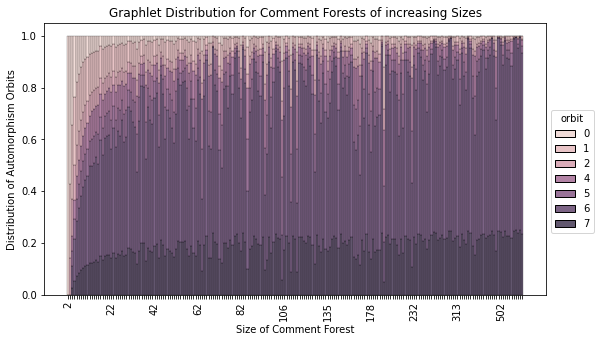

In [24]:
plt.figure(figsize=(9, 5))



g = sns.histplot(data=df, x="n_comments", weights="value", hue="orbit", multiple="stack", stat="count")
g.legend_.set_bbox_to_anchor((1.0, .7))
plt.xticks(rotation=90)
plt.xlabel("Size of Comment Forest")
plt.ylabel("Distribution of Automorphism Orbits")
plt.title("Graphlet Distribution for Comment Forests of increasing Sizes")


"""
# ticks every 50 n_comments
custom_ticks = []
next_i = 0
step = 50
for x in x_labels:
    if int(x) > step * next_i:
        custom_ticks.append(str(x))
        next_i += 1
    else:
        custom_ticks.append("")
"""

# ticks every 20 unique n_comments
custom_ticks = [str(x) if i % 20 == 0 else "" for i, x in enumerate(df["n_comments"].unique())]

g.set_xticks(range(len(custom_ticks)))
g.set_xticklabels(custom_ticks)


plt.savefig("graphlet_dist_large.pdf", bbox_inches="tight")
plt.show()

<h3> Comment Forests: Depth vs. Breadth </h3>

In [69]:
df = pd.read_csv("forest_stats.csv")
df

,total_comments,root_degree,avg_tree_size,avg_depth
0,6,6,1.0,1.0
1,22,14,1.6,1.2
2,5,3,1.7,1.3
3,68,66,1.0,1.0
4,6,6,1.0,1.0
...,...,...,...,...
4591,1,1,1.0,1.0
4592,1,1,1.0,1.0
4593,1,1,1.0,1.0
4594,4,2,2.0,2.0


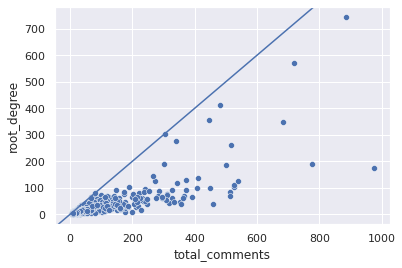

In [111]:
df_ = df[df["total_comments"] > 5]

plt.axline((0, 0), (100, 100))
sns.scatterplot(data=df_, x="total_comments", y="root_degree")
#plt.xlim([0, 100])
#plt.ylim([0, 100])
plt.show()

In [134]:
# Plot vs Expected values
df_["ratio"] = (df["root_degree"] - np.sqrt(df["total_comments"]))/df["total_comments"]
df_["ratio_tree_size"] = (df["avg_tree_size"] - np.sqrt(df["total_comments"])) / np.sqrt(df["total_comments"])
df_

,total_comments,root_degree,avg_tree_size,avg_depth,ratio,ratio_tree_size
0,6,6,1.0,1.0,0.591752,-0.591752
1,22,14,1.6,1.2,0.423163,-0.658879
3,68,66,1.0,1.0,0.849320,-0.878732
4,6,6,1.0,1.0,0.591752,-0.591752
6,82,74,1.1,1.1,0.792007,-0.878525
...,...,...,...,...,...,...
4568,9,3,3.0,2.3,0.000000,0.000000
4570,6,5,1.2,1.2,0.425085,-0.510102
4572,9,3,3.0,2.7,0.000000,0.000000
4578,539,125,4.3,2.3,0.188838,-0.814786


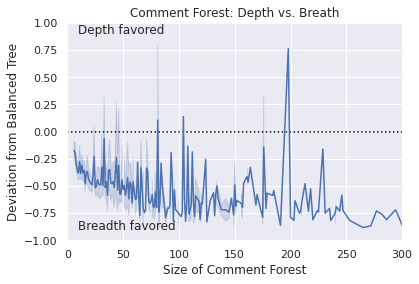

In [143]:
sns.set()
sns.lineplot(data=df_, x="total_comments", y="ratio_tree_size")
plt.xlim([0, 300])
plt.ylim([-1, 1])
plt.hlines(xmin=0, xmax=300, y=0, linestyles="dotted", color="black")
plt.title("Comment Forest: Depth vs. Breath")
plt.ylabel("Deviation from Balanced Tree")
plt.xlabel("Size of Comment Forest")
plt.text(10, 0.9, "Depth favored")
plt.text(10, -0.9, "Breadth favored")
plt.savefig("comment_forest_depth_vs_breadth.pdf", bbox_inches="tight")

In [93]:
df_["ratio"] = df["root_degree"] / df["total_comments"]
df_["comments_round"] = df["total_comments"] / 50
df_["comments_round"] = df_["comments_round"].astype(int)
df_

,total_comments,root_degree,avg_tree_size,avg_depth,ratio,comments_round
0,6,6,1.0,1.0,1.000000,0
1,22,14,1.6,1.2,0.636364,0
2,5,3,1.7,1.3,0.600000,0
3,68,66,1.0,1.0,0.970588,1
4,6,6,1.0,1.0,1.000000,0
...,...,...,...,...,...,...
4585,9,4,2.2,2.2,0.444444,0
4586,2,1,2.0,2.0,0.500000,0
4588,2,2,1.0,1.0,1.000000,0
4590,3,2,1.5,1.5,0.666667,0


In [135]:
df_ratio = pd.DataFrame(columns=["n_comments", "ratio"])

for n in df_["total_comments"].unique():
    ratios = df_[df_["total_comments"] == n]["ratio"]
    df_ratio = df_ratio.append({
        "n_comments": n,
        "ratio": ratios.mean()
    }, ignore_index=True)
    

print(df_ratio)

     n_comments     ratio
0           6.0  0.231928
1          22.0  0.264914
2          68.0  0.569909
3          82.0  0.481032
4          52.0  0.265171
..          ...       ...
201       265.0  0.478193
202       162.0  0.069581
203       124.0  0.031165
204       208.0  0.204701
205       539.0  0.188838

[206 rows x 2 columns]


In [136]:
xy = sorted([(row[1], row[2]) for row in df_ratio.itertuples()])
x,y = list(zip(*xy))

Text(10, 0.95, 'Breadth favored')

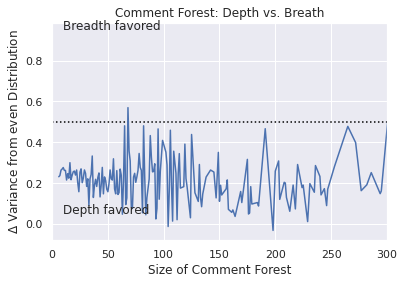

In [137]:
sns.set()
sns.lineplot(x, y)
plt.xlim([0, 300])
plt.hlines(xmin=0, xmax=300, y=0.5, linestyles="dotted", color="black")
plt.title("Comment Forest: Depth vs. Breath")
plt.ylabel("$\Delta$ Variance from even Distribution")
plt.xlabel("Size of Comment Forest")
plt.text(10, 0.05, "Depth favored")
plt.text(10, 0.95, "Breadth favored")

Text(0, 0.5, 'Avg Depth')

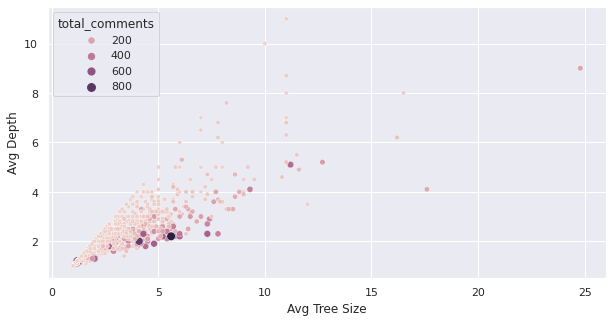

In [138]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=df_, x="avg_tree_size", y="avg_depth", hue="total_comments", size="total_comments")
plt.xlabel("Avg Tree Size")
plt.ylabel("Avg Depth")
#plt.xlim([0, 10])
#plt.ylim([0, 10])

<h3> GDV Kernel zwischen den verschiedenen Bins </h3>

In [180]:
len(dataframes)

4596

In [181]:
gdvs = defaultdict(list)
for df in dataframes:
    i = int(np.ceil(np.log2(df.shape[0])))
    gdv = df.sum(axis=0).to_numpy()[1:]
    gdv = np.divide(gdv, np.linalg.norm(gdv))
    gdvs[i].append(gdv)

In [202]:
# GDV-Kernel
lengths = []
for df in dataframes:
    lengths.append(df.shape[0])
    
n_bins = int(np.ceil(np.log2(max(lengths))))
K = np.zeros((n_bins, n_bins))


for i in tqdm(gdvs.keys()):
    for j in gdvs.keys():
        if i == j:
            intra_similarities = []
            for gdv1 in range(len(gdvs[i])):
                for gdv2 in range(len(gdvs[i])):
                    if gdv1 != gdv2 and gdv1 < gdv2:
                        # GDV Kernel
                        sim = np.inner(gdvs[i][gdv1], gdvs[i][gdv2])
                        intra_similarities.append(sim)

            K[i-1][i-1] = np.mean(intra_similarities)
            # K[(n_bins-1)-i][i-1] = np.mean(intra_similarities)
        else:
            inter_similarities = []
            for gdv1 in range(len(gdvs[i])):
                for gdv2 in range(len(gdvs[j])):
                    # GDV Kernel
                    sim = np.inner(gdvs[i][gdv1], gdvs[j][gdv2])
                    inter_similarities.append(sim)
            K[i-1][j-1] = np.mean(inter_similarities)
            #K[(n_bins-1)-i][j-1] = np.mean(inter_similarities)

K

100%|██████████| 10/10 [00:21<00:00,  2.15s/it]


array([[1.        , 0.81333024, 0.44737386, 0.23535967, 0.13356349,
        0.08895847, 0.03729719, 0.02153835, 0.00469855, 0.00133368],
       [0.81333024, 0.95317387, 0.72495516, 0.49071307, 0.34566924,
        0.26407279, 0.16406724, 0.12703665, 0.08025579, 0.06572718],
       [0.44737386, 0.72495516, 0.84084742, 0.78037571, 0.70509383,
        0.64644249, 0.5554088 , 0.51915909, 0.45466089, 0.43024129],
       [0.23535967, 0.49071307, 0.78037571, 0.84475608, 0.83792871,
        0.81173002, 0.7575833 , 0.73348785, 0.67779285, 0.6542913 ],
       [0.13356349, 0.34566924, 0.70509383, 0.83792871, 0.87549413,
        0.87339652, 0.85531034, 0.84312741, 0.803537  , 0.78460869],
       [0.08895847, 0.26407279, 0.64644249, 0.81173002, 0.87339652,
        0.88385576, 0.88741884, 0.88244351, 0.8533733 , 0.83770163],
       [0.03729719, 0.16406724, 0.5554088 , 0.7575833 , 0.85531034,
        0.88741884, 0.93531133, 0.9453285 , 0.94339314, 0.93673922],
       [0.02153835, 0.12703665, 0.5191590

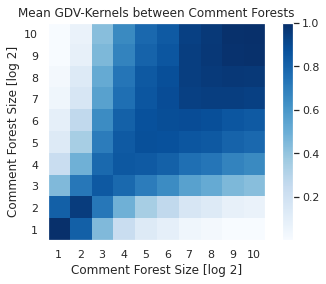

In [221]:
import seaborn as sns
sns.set()

df = pd.DataFrame(K)
df= df.iloc[::-1]


fig, ax = plt.subplots()
#plt.figure(figsize=(10,8))
plt.imshow(df, cmap=plt.cm.Blues)

# text
#for i in range(len(df)):
#    for j in range(len(df)):
#        ax.text(i, j, round(1-df[i][j], 2), ha="center", va="center")
        
plt.xticks([0,1,2,3,4,5,6,7,8,9], [1,2,3,4,5,6,7,8,9,10])
plt.yticks([0,1,2,3,4,5,6,7,8,9], [1,2,3,4,5,6,7,8,9,10][::-1])
plt.xlabel("Comment Forest Size [log 2]")
plt.ylabel("Comment Forest Size [log 2]")
plt.title("Mean GDV-Kernels between Comment Forests")
plt.colorbar()
plt.grid(False)

plt.savefig("mean_gdv_kernels.pdf")
plt.show()

<h3>Nx Atlas und Orbit Test-Code</h3>

1


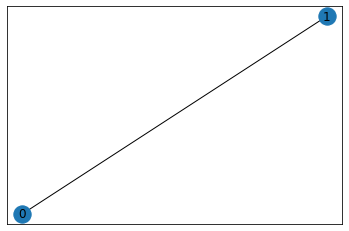

1


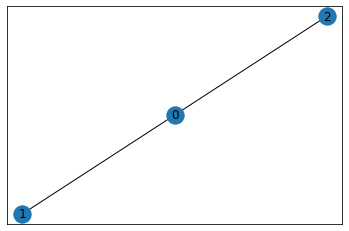

1


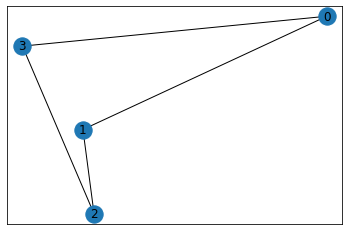

1


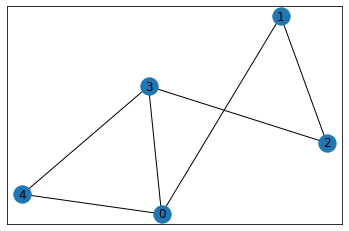

In [115]:
df = dataframes[0]
for cnt, automorphism in zip(df[df["id"] == 75].to_numpy()[0][1:], graphs):
    if cnt != 0:
        print(cnt)
        nx.draw_networkx(automorphism)
        plt.show()

In [94]:
from networkx.generators.atlas import *

G3


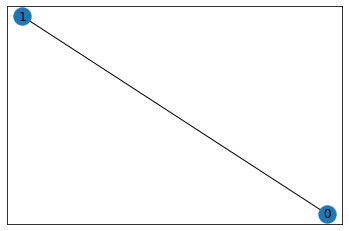

G6


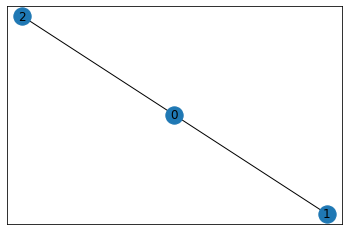

G7


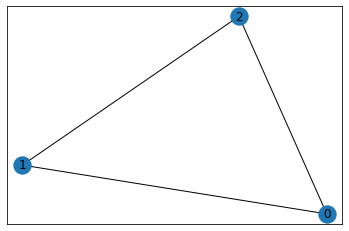

G13


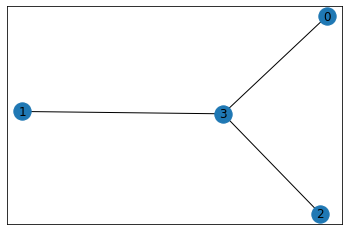

G14


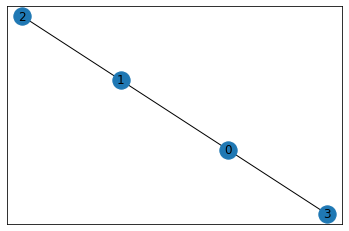

G15


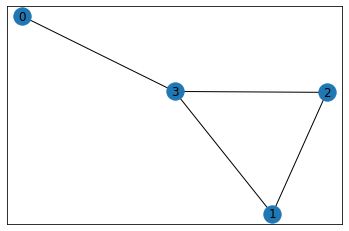

G16


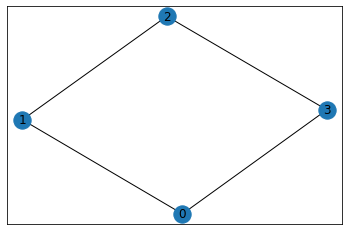

G17


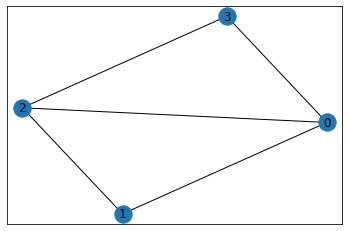

G18


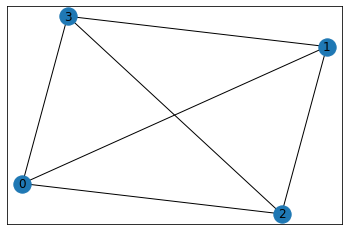

G29


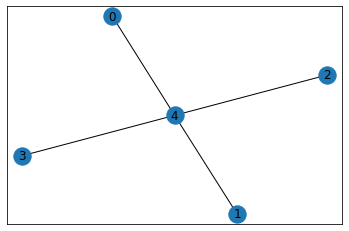

G30


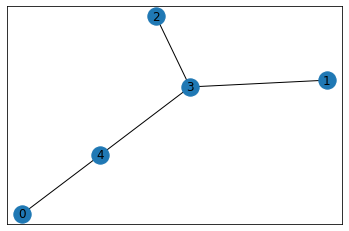

G31


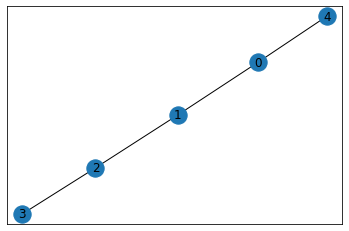

G34


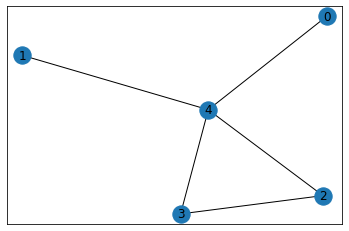

G35


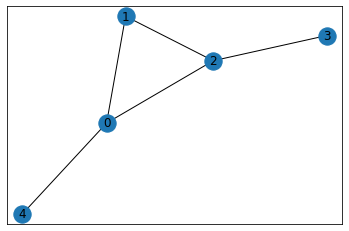

G36


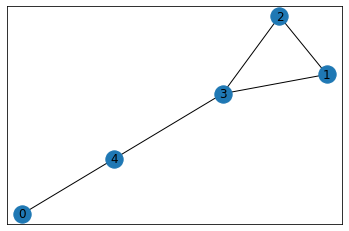

G37


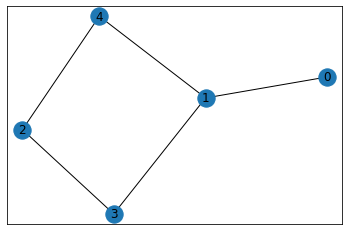

G38


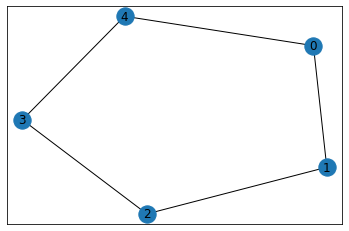

G40


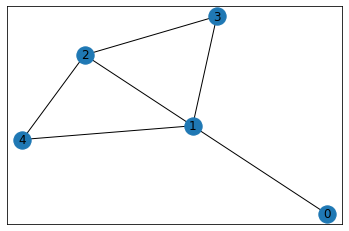

G41


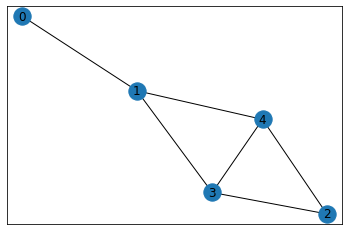

G42


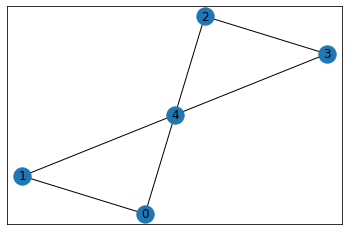

G43


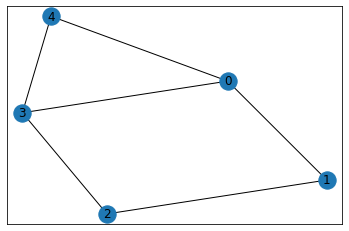

G44


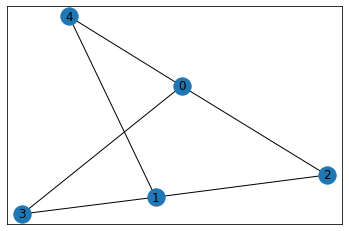

G45


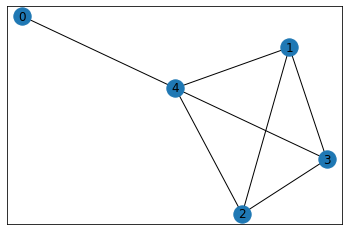

G46


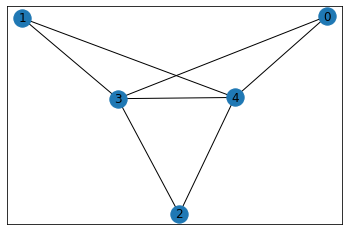

G47


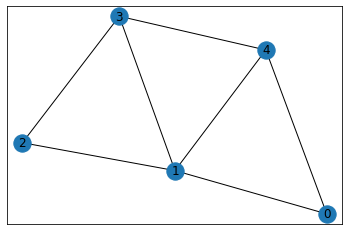

G48


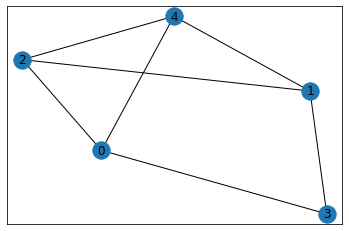

G49


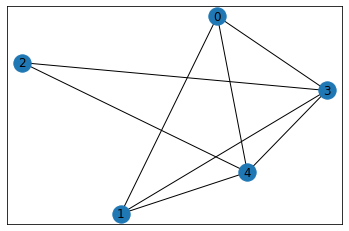

G50


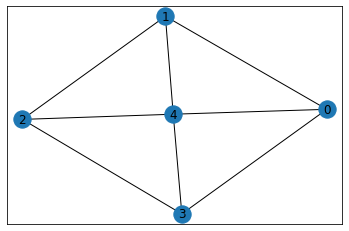

G51


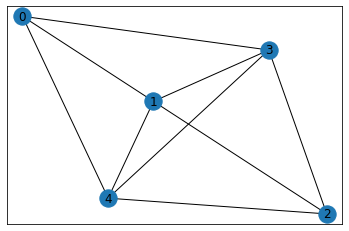

G52


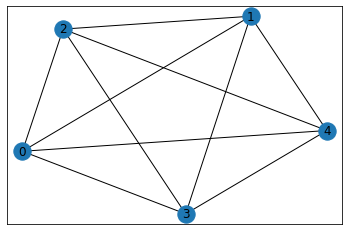

In [111]:
def enumerate_graphlets(N):
    graphs = []
    for graph in graph_atlas_g():
        if graph.number_of_nodes() > 1 and graph.number_of_nodes() < N + 1 and nx.is_connected(graph):
            print(graph)
            nx.draw_networkx(graph)
            plt.show()
            graphs.append(graph)
    return graphs

graphs = enumerate_graphlets(5)

In [116]:
def enumerate_graphs(graphlet_size):
    """
    Creating a hash table of the benchmark motifs.
    """
    graphs = graph_atlas_g()
    interesting_graphs = {i: [] for i in range(2, graphlet_size+1)}
    for graph in graphs:
        if graph.number_of_nodes() > 1 and graph.number_of_nodes() < graphlet_size+1:
            if nx.is_connected(graph):
                interesting_graphs[graph.number_of_nodes()].append(graph)
    return interesting_graphs